# Classifaction Using Time Window Without Memory

In [86]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score

In [3]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Flatten

/Users/shachiakyaagba/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [51]:
import itertools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn import preprocessing
import pandas.tseries
import pandas as pd
import numpy as np
np.random.seed(0)
import statsmodels as sm
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns


In [6]:
#Read in crypto currency data into a pandas dataframe
ticker_df = pd.read_csv('bitmex_BTCUSD_candles_5m_price_2.csv.gz')
ticker_df.head()

,Unnamed: 0,Date,Open,Close,High,Low,Trades,Volume,Y
0,0,2018-01-01T00:00:00.000Z,13838.5,13873.0,13961.0,13838.0,958,2041363,0
1,1,2018-01-01T00:05:00.000Z,13873.0,13800.0,13920.0,13800.0,1151,2595550,0
2,2,2018-01-01T00:10:00.000Z,13800.0,13771.5,13800.5,13675.0,1859,5809735,0
3,3,2018-01-01T00:15:00.000Z,13771.5,13769.0,13795.0,13711.0,861,1816360,0
4,4,2018-01-01T00:20:00.000Z,13769.0,13702.0,13775.5,13596.0,1235,4967912,0


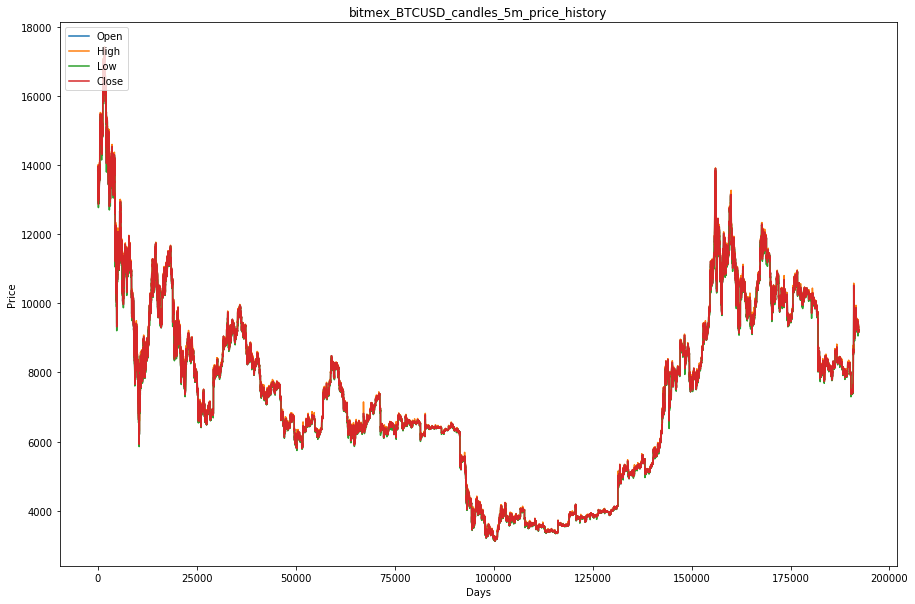

In [8]:
#plot prices to see trends
ticker_df[['Open', 'High', 'Low', 'Close']].plot(figsize = (15,10))
plt.title('bitmex_BTCUSD_candles_5m_price_history')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Open', 'High', 'Low', 'Close'], loc='upper left')
plt.show()

In [9]:
#Let's try some prediction now. 
#steps:create new dataframe, add new feature, model fit and optimize
ticker_df['Mean'] = (ticker_df['Open'] + ticker_df['High'] + ticker_df['Low'] + 
                         ticker_df['Close']) / 4

In [12]:
ticker_df['Prediction'] = ticker_df['Y'].shift(-24)

In [15]:
#drop Columns not being used
ticker_df.drop(columns = ['Unnamed: 0', 'Trades', 'Volume'], axis = 1, inplace = True)


In [17]:
#drop nan values
ticker_df.dropna(inplace = True)

In [19]:
ticker_df.head()

,Date,Open,Close,High,Low,Y,Mean,Prediction
0,2018-01-01T00:00:00.000Z,13838.5,13873.0,13961.0,13838.0,0,13877.625,1.0
1,2018-01-01T00:05:00.000Z,13873.0,13800.0,13920.0,13800.0,0,13848.250,0.0
2,2018-01-01T00:10:00.000Z,13800.0,13771.5,13800.5,13675.0,0,13761.750,1.0
3,2018-01-01T00:15:00.000Z,13771.5,13769.0,13795.0,13711.0,0,13761.625,0.0
4,2018-01-01T00:20:00.000Z,13769.0,13702.0,13775.5,13596.0,0,13710.625,1.0


In [20]:
#Change Date column datatype to timestamp
ticker_df['Date'] = pd.to_datetime(ticker_df['Date'], infer_datetime_format=True)

In [21]:
#set dataframe index to the Date column
ticker_df.set_index('Date', inplace = True)
ticker_df.index

DatetimeIndex(['2018-01-01 00:00:00', '2018-01-01 00:05:00',
               '2018-01-01 00:10:00', '2018-01-01 00:15:00',
               '2018-01-01 00:20:00', '2018-01-01 00:25:00',
               '2018-01-01 00:30:00', '2018-01-01 00:35:00',
               '2018-01-01 00:40:00', '2018-01-01 00:45:00',
               ...
               '2019-10-30 06:50:00', '2019-10-30 06:55:00',
               '2019-10-30 07:00:00', '2019-10-30 07:05:00',
               '2019-10-30 07:10:00', '2019-10-30 07:15:00',
               '2019-10-30 07:20:00', '2019-10-30 07:25:00',
               '2019-10-30 07:30:00', '2019-10-30 07:35:00'],
              dtype='datetime64[ns]', name='Date', length=192188, freq=None)

In [22]:
ticker_df.head()

,Open,Close,High,Low,Y,Mean,Prediction
Date,,,,,,,
2018-01-01 00:00:00,13838.5,13873.0,13961.0,13838.0,0,13877.625,1.0
2018-01-01 00:05:00,13873.0,13800.0,13920.0,13800.0,0,13848.250,0.0
2018-01-01 00:10:00,13800.0,13771.5,13800.5,13675.0,0,13761.750,1.0
2018-01-01 00:15:00,13771.5,13769.0,13795.0,13711.0,0,13761.625,0.0
2018-01-01 00:20:00,13769.0,13702.0,13775.5,13596.0,0,13710.625,1.0


In [33]:
ticker_np = ticker_df.drop('Prediction', axis = 1)
normalized_df = (ticker_np - ticker_np.min())/(ticker_np.max()- ticker_np.min())
normalized_df['Prediction'] = ticker_df["Prediction"]

train_size = int(len(normalized_df)*0.7)
val_size = int(len(normalized_df)*0.2) + train_size
train= normalized_df[0:train_size]
val = normalized_df[train_size: val_size]
test = normalized_df[val_size: len(ticker_np)]
print('Observations: %d' % (len(ticker_df)))
print('Training Observations: %d' % (len(train)))
print('Validation Observations: %d' % (len(val)))
print('Testing Observations: %d' % (len(test)))

Observations: 192188
Training Observations: 134531
Validation Observations: 38437
Testing Observations: 19220


In [34]:
train.head()

,Open,Close,High,Low,Y,Mean,Prediction
Date,,,,,,,
2018-01-01 00:00:00,0.749799,0.752214,0.757718,0.758941,0.0,0.756727,1.0
2018-01-01 00:05:00,0.752214,0.747103,0.754848,0.756250,0.0,0.754659,0.0
2018-01-01 00:10:00,0.747103,0.745108,0.746482,0.747397,0.0,0.748567,1.0
2018-01-01 00:15:00,0.745108,0.744933,0.746097,0.749947,0.0,0.748559,0.0
2018-01-01 00:20:00,0.744933,0.740242,0.744732,0.741803,0.0,0.744967,1.0


In [36]:
X_train = train.drop('Prediction', axis = 1)
y_train = train['Prediction']
X_val = val.drop('Prediction', axis = 1)
y_val = val['Prediction']
X_test = test.drop('Prediction', axis = 1)
y_test = test['Prediction']

# Logistic Regression

In [74]:
log_clf = LogisticRegression()
log_clf.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [77]:
#Training Accuracy
log_training_accuracy = log_clf.score(X_train, y_train)
print('Training Accuracy: %.2f%%' % (log_training_accuracy*100.0))

Training Accuracy: 54.43%


In [78]:
#Validation Accuracy
log_validation_accuracy = log_clf.score(X_val, y_val)
print('Validation Accuracy: %.2f%%' % (log_validation_accuracy*100.0))

Validation Accuracy: 51.37%


In [85]:
#Testing Accuracy
log_validation_accuracy = log_clf.score(X_test, y_test)
print('Validation Accuracy: %.2f%%' % (log_validation_accuracy*100.0))

Validation Accuracy: 51.29%


# Random Forrest Classifier

In [38]:
from sklearn.model_selection import RandomizedSearchCV

rfc = RandomForestClassifier()

# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 250, num = 10)]
# number of features at every split
max_features = ['auto', 'sqrt']

# max depth
max_depth = [int(x) for x in np.linspace(50, 100, num = 11)]
max_depth.append(None)
# create random grid
random_grid = {
 'n_estimators': n_estimators,
 'criterion': ['entropy', 'gini'],
 'max_features': max_features,
 'max_depth': max_depth
 }
# Random search of parameters
rfc_random = RandomizedSearchCV(estimator = rfc, scoring = 'accuracy', param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, random_state=42, n_jobs = 2)
# Fit the model
rfc_random.fit(X_train, y_train)

# Best accuracy
print('Best accuracy: %.3f' % rfc_random.best_score_)

# print results
print(rfc_random.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] n_estimators=216, max_features=sqrt, max_depth=65, criterion=entropy 
[CV] n_estimators=216, max_features=sqrt, max_depth=65, criterion=entropy 
[CV]  n_estimators=216, max_features=sqrt, max_depth=65, criterion=entropy, total= 1.3min
[CV] n_estimators=216, max_features=sqrt, max_depth=65, criterion=entropy 
[CV]  n_estimators=216, max_features=sqrt, max_depth=65, criterion=entropy, total= 2.1min
[CV] n_estimators=222, max_features=sqrt, max_depth=90, criterion=gini 
[CV]  n_estimators=222, max_features=sqrt, max_depth=90, criterion=gini, total= 1.4min
[CV] n_estimators=222, max_features=sqrt, max_depth=90, criterion=gini 
[CV]  n_estimators=216, max_features=sqrt, max_depth=65, criterion=entropy, total= 2.6min
[CV] n_estimators=222, max_features=sqrt, max_depth=90, criterion=gini 
[CV]  n_estimators=222, max_features=sqrt, max_depth=90, criterion=gini, total= 1.8min
[CV] n_estimators=222, max_features=sqrt, max_depth=85

[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed: 33.2min


[CV] n_estimators=216, max_features=sqrt, max_depth=95, criterion=gini 
[CV]  n_estimators=216, max_features=sqrt, max_depth=95, criterion=gini, total= 1.6min
[CV] n_estimators=244, max_features=sqrt, max_depth=60, criterion=gini 
[CV]  n_estimators=216, max_features=sqrt, max_depth=95, criterion=gini, total= 1.8min
[CV] n_estimators=244, max_features=sqrt, max_depth=60, criterion=gini 
[CV]  n_estimators=244, max_features=sqrt, max_depth=60, criterion=gini, total= 1.2min
[CV] n_estimators=244, max_features=sqrt, max_depth=60, criterion=gini 
[CV]  n_estimators=244, max_features=sqrt, max_depth=60, criterion=gini, total= 1.6min
[CV] n_estimators=200, max_features=sqrt, max_depth=55, criterion=entropy 
[CV]  n_estimators=244, max_features=sqrt, max_depth=60, criterion=gini, total= 1.7min
[CV] n_estimators=200, max_features=sqrt, max_depth=55, criterion=entropy 
[CV]  n_estimators=200, max_features=sqrt, max_depth=55, criterion=entropy, total=  59.4s
[CV] n_estimators=200, max_features=s

[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed: 53.2min finished


Best accuracy: 0.490
{'n_estimators': 250, 'max_features': 'auto', 'max_depth': 50, 'criterion': 'entropy'}


# Random Forrest Classifier

In [39]:
classifier = RandomForestClassifier(n_estimators = 200,random_state = 101)
classifier.fit(X_train,y_train)
accuracy = classifier.score(X_val,y_val)
accuracy = accuracy*100
accuracy = float('{0:.2f}'.format(accuracy))
print ('Accuracy is: ',accuracy,'%')

Accuracy is:  50.18 %


In [60]:
classifier

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=101, verbose=0, warm_start=False)

In [73]:
#Training Accuracy
forrest_training_accuracy = classifier.score(X_train, y_train)
print('Training Accuracy: %.2f%%' % (forrest_training_accuracy*100.0))

Training Accuracy: 97.65%


In [82]:
#Validation Accuracy
forrest_validation_accuracy = classifier.score(X_val, y_val)
print('Validation Accuracy: %.2f%%' % (forrest_validation_accuracy*100.0))

Validation Accuracy: 50.18%


From the above training and validation metrics we can see that the model is overfitting the training data. This means that generalization cannot occur. We will now move into the hyperparameter tuning stage.

In [84]:
#Testing Accuracy
forrest_validation_accuracy = classifier.score(X_test, y_test)
print('Validation Accuracy: %.2f%%' % (forrest_validation_accuracy*100.0))

Validation Accuracy: 50.36%


# Adaboost Classifier

In [53]:
adaboost_clf = AdaBoostClassifier()
adaboost_mean_cv_score = np.mean(cross_val_score(adaboost_clf, X_train, y_train, cv=3))

adaboost_param_grid = {
    'n_estimators': [50, 100, 250],
    'learning_rate': [1.0, 0.5, 0.1]
}

In [54]:
adaboost_grid_search = GridSearchCV(adaboost_clf, adaboost_param_grid, cv=3)
adaboost_grid_search.fit(X_train, y_train)

print("Training Accuracy: {:.4}%".format(adaboost_grid_search.best_score_ * 100))
print("")
print("Optimal Parameters: {}".format(adaboost_grid_search.best_params_))

Testing Accuracy: 51.94%

Optimal Parameters: {'learning_rate': 0.1, 'n_estimators': 50}


In [55]:
ada_classifier = AdaBoostClassifier(n_estimators = 40, learning_rate = 0.1)
ada_classifier.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=40, random_state=None)

In [79]:
#Training Accuracy
ada_training_accuracy = ada_classifier.score(X_train, y_train)
print('Training Accuracy: %.2f%%' % (ada_training_accuracy*100.0))

Training Accuracy: 54.43%


In [80]:
#Validation Accuracy
ada_validation_accuracy = ada_classifier.score(X_val, y_val)
print('Validation Accuracy: %.2f%%' % (ada_validation_accuracy*100.0))

Validation Accuracy: 51.36%


In [81]:
#Testing Accuracy
ada_testing_accuracy = ada_classifier.score(X_test, y_test)
print('Testing Accuracy: %.2f%%' % (ada_testing_accuracy*100.0))

Testing Accuracy: 51.29%


# XGBoost Classifier

In [66]:
import xgboost as xgb

In [67]:
param_grid = {
    "learning_rate": [0.1],
    'max_depth': [6, 15],
    'min_child_weight': [10],
    'subsample': [ 0.7],
    'n_estimators': [5, 30, 100, 250],
}

In [68]:
clf = xgb.XGBClassifier()
grid_clf = GridSearchCV(clf, param_grid, scoring='accuracy', cv=None, n_jobs=1)
grid_clf.fit(X_train, y_train)

best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train)
val_preds = grid_clf.predict(X_val)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_val, val_preds)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

/Users/shachiakyaagba/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/shachiakyaagba/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/shachiakyaagba/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/shachiakyaagba/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: Th

/Users/shachiakyaagba/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/shachiakyaagba/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/shachiakyaagba/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/shachiakyaagba/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: Th

Grid Search found the following optimal parameters: 
learning_rate: 0.1
max_depth: 6
min_child_weight: 10
n_estimators: 5
subsample: 0.7

Training Accuracy: 54.99%
Validation accuracy: 51.34%


/Users/shachiakyaagba/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/shachiakyaagba/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [87]:
#Training Accuracy
training_accuracy = grid_clf.score(X_train, y_train)
print('Training Accuracy: %.2f%%' % (training_accuracy*100.0))

Training Accuracy: 54.99%


/Users/shachiakyaagba/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [70]:
#Validation Accuracy
validation_accuracy = grid_clf.score(X_val, y_val)
print('Validation Accuracy: %.2f%%' % (validation_accuracy*100.0))

Validation Accuracy: 51.34%


/Users/shachiakyaagba/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [72]:
#Testing Accuracy
testing_accuracy = grid_clf.score(X_test, y_test)
print('Testing Accuracy: %.2f%%' % (testing_accuracy*100.0))

Testing Accuracy: 51.23%


/Users/shachiakyaagba/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
